In [22]:
import os
import sys

import warnings 
warnings.filterwarnings('ignore')

# include app-wide functions 
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('utils.py'))))
import utils

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
import pickle 
import random
import string
import json

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [23]:
df = utils.load_data()  # cleaned dataset

## some exploratory data analysis

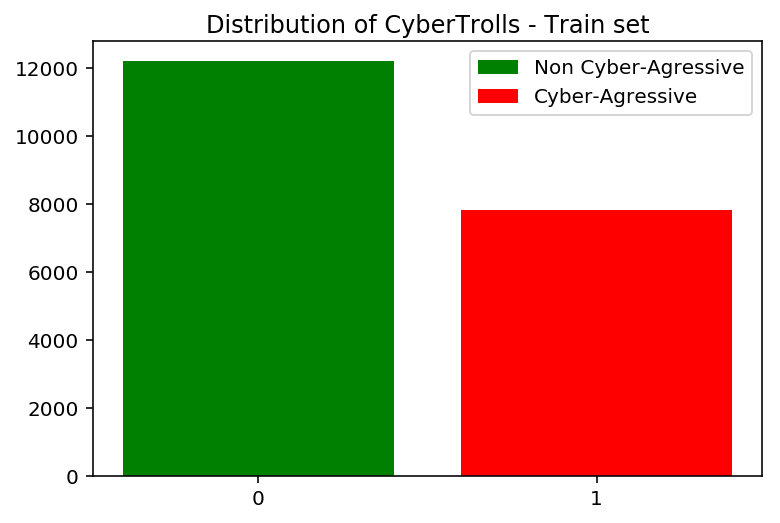

In [24]:
# distribution of cyber trolls vs non-cyber trolls
counter = Counter(df.label)
plt.title('Distribution of CyberTrolls - Train set')
plt.bar(list(counter.keys())[0], list(counter.values())[0], align='center', color='g', label='Non Cyber-Agressive')
plt.bar(list(counter.keys())[1], list(counter.values())[1], align='center', color='r', label='Cyber-Agressive')
plt.xticks(list(set(df.label)))
plt.legend()
plt.show()

In [26]:
# sample some of the online comments
utils.sample_data(df, n=10)  # feature engineering (create number hashtags col?)

Label: 0
Index: 3978	omg wishthe bitch kocker lol

Label: 0
Index: 9074	ballfuck shes real get it vv

Label: 0
Index: 6092	awww feel better hate wen tht happens

Label: 0
Index: 10289	what snack movie theatre

Label: 0
Index: 6512	surprise party u yes no why not

Label: 0
Index: 10345	i dont know like pollyanna

Label: 0
Index: 11343	sound puuurty legit

Label: 0
Index: 11527	hahahaha okay good like d ahhh

Label: 0
Index: 646	loser buy winner month worth diaper hehehe

Label: 0
Index: 5433	the job sitch suck my husband carpenter who think building economy nobody

Label: 1
Index: 6496	excited seeing remembered itv fa cup right god hate itv

Label: 1
Index: 3849	goddamn kjfuck time httptinyurlcomnvtl

Label: 1
Index: 4887	turn i hate shopping too way many sound smell i want pee everything

Label: 1
Index: 2178	nerd

Label: 1
Index: 2311	haha i always say that girl i rock cock out hah

Label: 1
Index: 3936	left slut named kasumi

Label: 1
Index: 1689	i clue ive stumbled upon i laughed as

In [10]:
# most common words by label
trolls = Counter(' '.join(list(df[df.label == 1].text)).split())
non_trolls = Counter(' '.join(list(df[df.label == 0].text)).split())

print('Cyber Trolls')
print(*trolls.most_common()[:5], sep='\n')
print('\nNon Cyber Trolls')
print(*non_trolls.most_common()[:5], sep='\n')

Cyber Trolls
('i', 2981)
('hate', 1313)
('damn', 1059)
('fuck', 1036)
('as', 1022)

Non Cyber Trolls
('i', 3839)
('hate', 1488)
('damn', 1307)
('im', 988)
('like', 942)


In [3]:
## Save vectorizer in ./model_assets
utils.persist_vectorizer(vectorizer, 'test_v.0.0')    

## text feature extractors

In [12]:
# bag-of-words encoding
enc = utils.build_encoder(df.text, count_vectorizer=True)
count_vectorized = enc.fit_transform(df.text).toarray()

# tf-idf encoding
enc = utils.build_encoder(df.text, tf_idf=True)
tf_idf = enc.fit_transform(df.text).toarray()

print(tf_idf.shape ==  count_vectorized.shape)

True


# Model dev

In [15]:
X_train, X_test, y_train, y_test = train_test_split(count_vectorized, df.label)

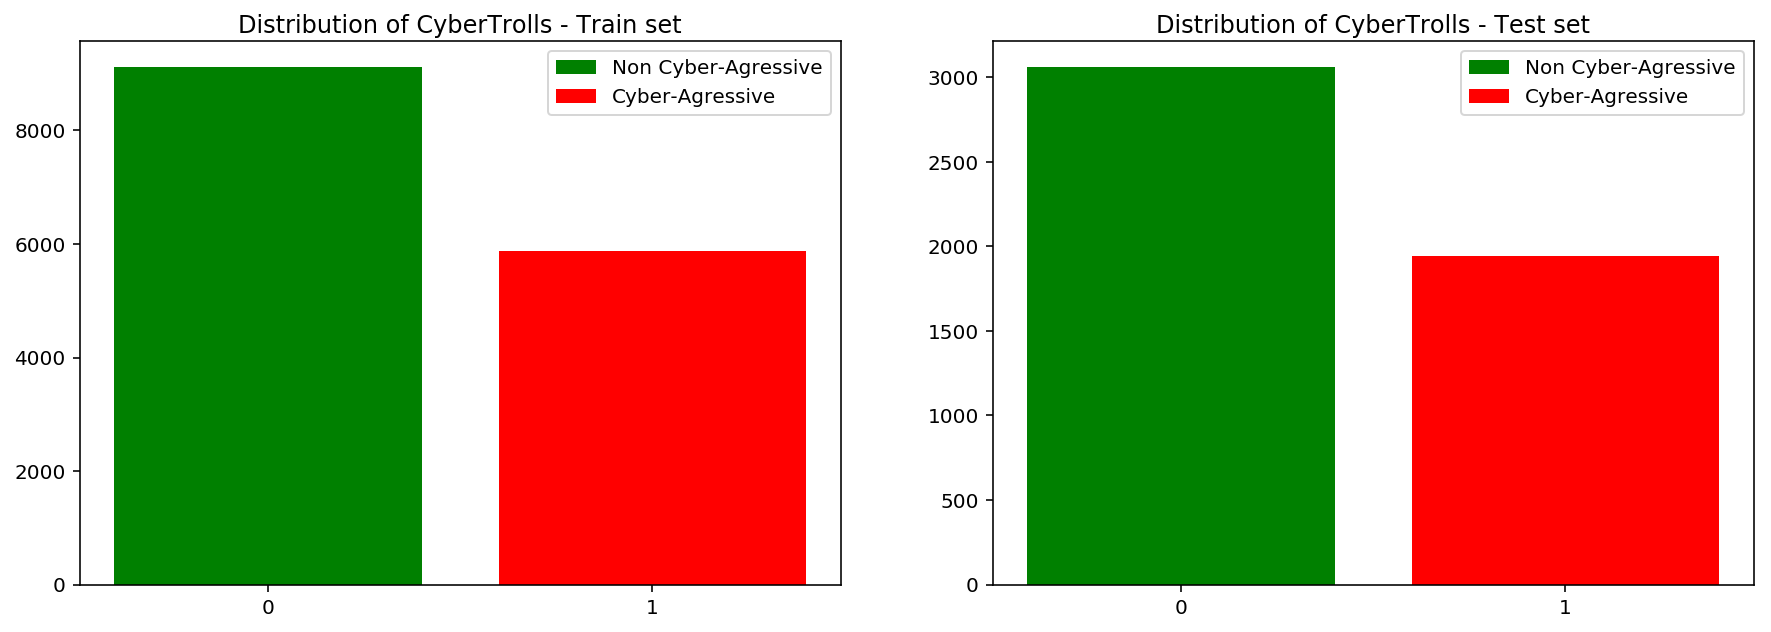

In [16]:
# Show of labels train/test sets
fig, axs = plt.subplots(1, 2, figsize=(15,5))

train_count = Counter(y_train)
axs[0].set_title('Distribution of CyberTrolls - Train set')
axs[0].bar(list(train_count.keys())[0], list(train_count.values())[0], align='center', color='g', label='Non Cyber-Agressive')
axs[0].bar(list(train_count.keys())[1], list(train_count.values())[1], align='center', color='r', label='Cyber-Agressive')
axs[0].set_xticks(list(set(y_train)))
axs[0].legend()

test_count = Counter(y_test)
axs[1].set_title('Distribution of CyberTrolls - Test set')
axs[1].bar(list(test_count.keys())[0], list(test_count.values())[0], align='center', color='g', label='Non Cyber-Agressive')
axs[1].bar(list(test_count.keys())[1], list(test_count.values())[1], align='center', color='r', label='Cyber-Agressive')
axs[1].set_xticks(list(set(y_test)))
axs[1].legend()

plt.show()

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def display_results(clf, data):
    """ Prints testing and training accuracies along with other model 
        validation metrics.
    
    Parameters
    ---------------
        clf: (scikit-learn model) predictive model to test
        data: (dict) training and testing data for model
        
        
    """
    train_accuracy = clf.score(data['X_train'], data['y_train'])
    test_accuracy = clf.score(data['X_test'], data['y_test'])
    y_pred = clf.predict(data['X_test'])
        
    print('{:>20s} {:.2f}'.format('Train Accuracy:', train_accuracy))
    print('{:>20s} {:.2f}'.format('Test Accuracy:', test_accuracy))
    print(confusion_matrix(data['y_test'], y_pred))
    
    

# TODO: cross validation scores, precision/recall calculation
def build_model(kind, data, **kwargs):
    """ Builds Logistic Regression model 
    
    Parameters
    -------------
        kind   : (str) indicating the model to build. The possible values are 
                       ('logistic', 'svc').
        kwargs : (dict) of key value pairs of model build parameters
        data   : (dict) containing training and testing sets e.g data['X_train']
        returns: (clf) trained classifier

    """
    if kind == 'logistic':
        
        print('Building Logistic Regression model.\n')
        clf = LogisticRegression(**kwargs)
        clf.fit(data['X_train'], data['y_train']) 
        display_results(clf, data)
        return clf
    
    if kind == 'svc':
        
        print('Building Support Vector Machine model.\n')
        clf = LinearSVC(**kwargs)
        clf.fit(data['X_train'], data['y_train'])
        display_results(clf, data)    
        return clf


In [68]:
# train/test data
data = {
    'X_train': X_train,
    'X_test': X_test, 
    'y_train': y_train,
    'y_test': y_test
}

In [67]:
# build logistic regression model params
kwargs = {
    'solver': 'saga',
    'C': 0.3,
    'n_jobs': 2,
    'max_iter': 100
}

log_reg = build_model(kind='logistic', data=data, **kwargs)

Building Logistic Regression model
     Train Accuracy: 0.79
      Test Accuracy: 0.74
[[2597  463]
 [ 831 1110]]


In [85]:
# svc params
kwargs = {
    'penalty': 'l2',
    'loss': 'squared_hinge',
    'C': 1.0,
    'max_iter': 1000
}

svc = build_model(kind='svc', data=data, **kwargs)

Building Support Vector Machine model.

     Train Accuracy: 0.97
      Test Accuracy: 0.86
[[2540  520]
 [ 185 1756]]


## save model and vectorizer

In [10]:
persist_model(clf, 'test_v.0.0')
persist_model(clf, 'test_v.0.0')

Model Saved.
